# Import packages

In [1]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
SEED=123
np.random.seed(SEED)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import load_model

# Set path

In [4]:
BASEPATH = '/home/ubuntu/w210_melanoma/data'

df_train_full = pd.read_csv(os.path.join(BASEPATH, 'metadata_train.csv'))

train_path = BASEPATH + '/train_7525'
train_dir = pathlib.Path(train_path)

test_path = BASEPATH + '/ISIC_2020_Test_Input'
test_dir = pathlib.Path(test_path)

# Configurations

In [5]:
CFG = dict(
        batch_size        =  16,     
        epochs            =  50, #10,  
        verbose           =   1,   
        workers           =   4,   

        optimizer         = 'adam', 

        RANDOM_STATE      =  123,   
    
        # Path to save a model
        path_model        = '/home/ubuntu/w210_melanoma/model/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Postprocessing
        label_smooth_fac  =  0.00,      
)

# Data split and generation

In [6]:
#train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [49]:
train_generator = ImageDataGenerator(
                  rescale=1./255, 
                  validation_split=0.2,
                  rotation_range=45, # was Rotate 90 degree
                  horizontal_flip=True, # new
                  vertical_flip=True, # new 
                  samplewise_std_normalization=True , # Boolean. Divide each input by its std.
                  width_shift_range=0.3,
                  height_shift_range=0.3,
                  brightness_range=[0.2,1.0]
                  ) 
valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [50]:
train_generator = train_generator.flow_from_directory(train_dir,
                                                    subset='training',                  
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical',
                                                    shuffle=True
                                                    )


valid_generator = valid_generator.flow_from_directory(train_dir,
                                                     subset='validation',              
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,
                                                     class_mode='categorical',
                                                     shuffle=False
                                                     )

Found 1908 images belonging to 2 classes.
Found 476 images belonging to 2 classes.


In [51]:
np.mean(valid_generator.classes)

0.24369747899159663

# Re-train the model pre-trained with 50/50 data

In [59]:
model = load_model('/home/ubuntu/w210_melanoma/model/ResNet50-DA-balanced-28-0.48.hdf5')

In [60]:
model.layers[0].trainable = False

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
model.compile(
    optimizer = CFG['optimizer'],
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
    #loss = 'binary_crossentropy',
    metrics=[tf.keras.metrics.Recall()]
)

# Fit model

In [14]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

cb_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [15]:
#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(filepath = CFG['path_model']+'ResNet50-DA-5050-7525-{epoch:02d}-{val_recall:.4f}.hdf5',
                                   monitor  = 'val_recall', 
                                   verbose  = CFG['verbose'], 
                                   save_best_only=True, 
                                   mode='max'
                                  )

callbacks_list = [cb_lr_scheduler, cb_checkpointer]

history = model.fit(train_generator, 
                    epochs=CFG['epochs'], 
                    workers=CFG['workers'],
                    validation_data=valid_generator, 
                    callbacks = callbacks_list
                    )

Epoch 1/50
120/120 [==============================] - 167s 1s/step - loss: 1.3109 - recall: 0.5902 - val_loss: 0.4200 - val_recall: 0.7878

Epoch 00001: val_recall improved from -inf to 0.78782, saving model to /home/ubuntu/w210_melanoma/model/ResNet50-DA-5050-7525-01-0.7878.hdf5
Epoch 2/50
120/120 [==============================] - 159s 1s/step - loss: 0.5487 - recall: 0.7374 - val_loss: 0.4288 - val_recall: 0.7773

Epoch 00002: val_recall did not improve from 0.78782
Epoch 3/50
120/120 [==============================] - 164s 1s/step - loss: 0.5240 - recall: 0.7450 - val_loss: 0.4257 - val_recall: 0.7815

Epoch 00003: val_recall did not improve from 0.78782
Epoch 4/50
120/120 [==============================] - 160s 1s/step - loss: 0.5049 - recall: 0.7646 - val_loss: 0.4244 - val_recall: 0.7752

Epoch 00004: val_recall did not improve from 0.78782
Epoch 5/50
120/120 [==============================] - 168s 1s/step - loss: 0.5204 - recall: 0.7619 - val_loss: 0.4103 - val_recall: 0.7962



120/120 [==============================] - 167s 1s/step - loss: 0.4641 - recall: 0.7688 - val_loss: 0.4253 - val_recall: 0.7815

Epoch 00042: val_recall did not improve from 0.79832
Epoch 43/50
120/120 [==============================] - 163s 1s/step - loss: 0.4464 - recall: 0.7918 - val_loss: 0.4245 - val_recall: 0.7815

Epoch 00043: val_recall did not improve from 0.79832
Epoch 44/50
120/120 [==============================] - 165s 1s/step - loss: 0.4540 - recall: 0.7783 - val_loss: 0.4257 - val_recall: 0.7815

Epoch 00044: val_recall did not improve from 0.79832
Epoch 45/50
120/120 [==============================] - 167s 1s/step - loss: 0.4546 - recall: 0.7679 - val_loss: 0.4255 - val_recall: 0.7815

Epoch 00045: val_recall did not improve from 0.79832
Epoch 46/50
120/120 [==============================] - 169s 1s/step - loss: 0.4604 - recall: 0.7690 - val_loss: 0.4252 - val_recall: 0.7794

Epoch 00046: val_recall did not improve from 0.79832
Epoch 47/50
120/120 [=====================

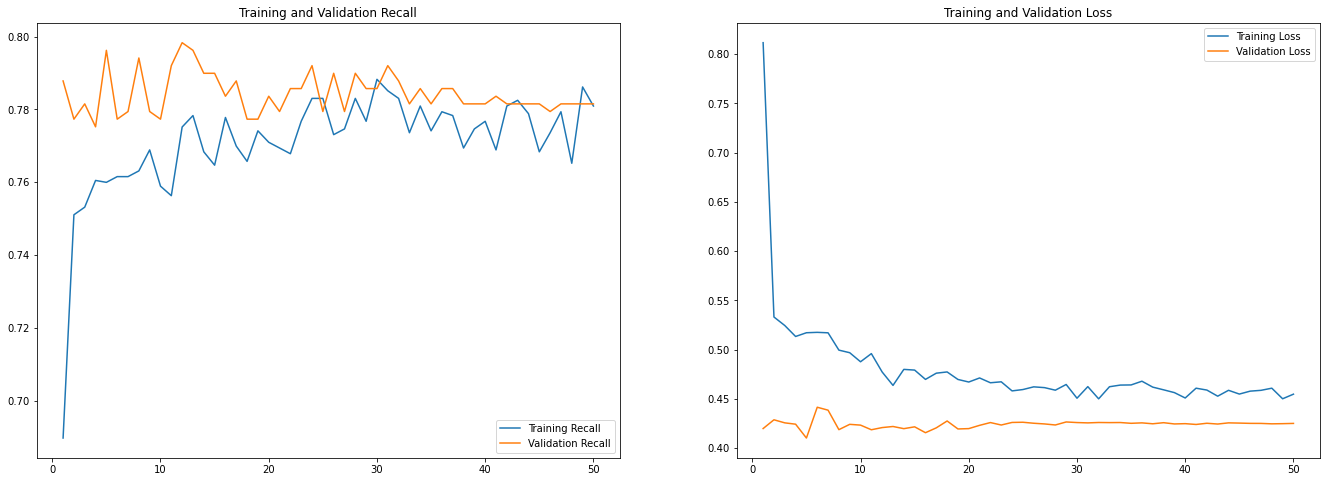

In [16]:
acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['recall']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Make predictions on the Validation set and analyze the results

In [69]:
model = load_model('/home/ubuntu/w210_melanoma/model/ResNet50-DA-5050-7525-12-0.7983.hdf5')

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [71]:
true_label = valid_generator.classes

In [72]:
pred_probs = model.predict(valid_generator)

In [73]:
predictions = np.vstack((true_label, pred_probs[:,1])).T

In [74]:
TP, TN, FP, FN = 0, 0, 0, 0

for tpl in predictions:
    if tpl[0] == 0:
        if tpl[1] < 0.5:
            TN += 1
        else:
            FP += 1
    else:
        if tpl[1] < 0.5:
            FN += 1
        else:
            TP += 1

In [75]:
np.seterr(divide='ignore', invalid='ignore')
print("True Positive:", TP)
print("True Negative:", TN)
print("False Positive:", FP)
print("False Negative:", FN)
print("------------------------------")
print("Accuracy:", (TP+TN)/(TP+TN+FP+FN))
print("Precision:", np.nan_to_num(np.divide(TP, TP+FP)))
print("Recall:", np.nan_to_num(np.divide(TP, TP+FN)))
print("F-1 Score:", 2*TP/(2*TP+FP+FN))

True Positive: 57
True Negative: 323
False Positive: 37
False Negative: 59
------------------------------
Accuracy: 0.7983193277310925
Precision: 0.6063829787234043
Recall: 0.49137931034482757
F-1 Score: 0.5428571428571428
